In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import torch.nn
import torch.optim
import torch.utils.data
import h5py
from os.path import exists
import time
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score


# Importing LearningCutsUtils
from LearningCutsUtils import OneToOneLinear, EfficiencyScanNetwork
from LearningCutsUtils import loss_fn, effic_loss_fn, lossvars
import LearningCutsUtils.Utils as LCU

In [2]:
# Prep Data using Pandas
x_sig_data=None
y_sig_data=None

x_bkg_data=None
y_bkg_data=None

num_sig_events=0
num_bkg_events=0

# Need to copy the last branch, Rll, so that we have a total of 5 branches
branches=(
    'lep1MT_Met',
    'lep2MT_Met',
    'met_Et',
    'Rll')

# open signal
mass=200
split=30
filepath='/data/mhance/SUSY/Compressed/'
filebase='SusySkimSlep_v0.2_SlepSignals__'
filename='MGPy8EG_A14N23LO_SlepSlep_dir_2L2MET75_%dp0_%dp0_NoSys' % (mass,mass-split)
filesuff='.hf5'
fullname=filepath+filebase+filename+filesuff

new_branches = ('lep1MT_Met',
    'lep2MT_Met',
    'met_Et',
    'Rll',
    'Rll_lt')
# Makes data frame for signal events
num_sig_events = len(np.array(h5py.File(fullname)['MGPy8EG_A14N23LO_SlepSlep_dir_2L2MET75_200p0_170p0_NoSys'])["nJet30"])
df1 = pd.DataFrame(np.array(h5py.File(fullname)['MGPy8EG_A14N23LO_SlepSlep_dir_2L2MET75_200p0_170p0_NoSys']['lep1MT_Met', 'lep2MT_Met', 'met_Et','Rll']), columns=branches)
df1["Rll_lt"] = df1.iloc[:, -1]
# Makes ndarray for xsignal using data frame
x_sig_data = df1[:].values
y_sig_data=np.ones(num_sig_events)

print(fullname)
print("Extracted %7d signal events" % num_sig_events)

fullname=filepath+"SusySkimSlep_v0.2_diboson2L__diboson2L_NoSys"+filesuff
df2 = pd.DataFrame(np.array(h5py.File(fullname)['diboson2L_NoSys']['lep1MT_Met', 'lep2MT_Met', 'met_Et','Rll']), columns=branches)
df2["Rll_lt"] = df2.iloc[:, -1]

num_events=0

num_bkg_events=len(np.array(h5py.File(fullname)['diboson2L_NoSys']["nJet30"]))
x_bkg_data = df2[:].values
y_bkg_data=np.zeros(num_bkg_events)
print("Extracted %7d background events" % num_bkg_events)

/data/mhance/SUSY/Compressed/SusySkimSlep_v0.2_SlepSignals__MGPy8EG_A14N23LO_SlepSlep_dir_2L2MET75_200p0_170p0_NoSys.hf5
Extracted  251106 signal events
Extracted  126906 background events


In [3]:
x_data=None
y_data=None
if num_bkg_events>num_sig_events:
    x_data = np.concatenate((x_sig_data,x_bkg_data[:num_sig_events]))
    y_data = np.concatenate((y_sig_data,y_bkg_data[:num_sig_events]))
else:
    x_data = np.concatenate((x_sig_data[:num_bkg_events],x_bkg_data))
    y_data = np.concatenate((y_sig_data[:num_bkg_events],y_bkg_data))

print(y_sig_data)
print(y_data)

[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 0. 0. 0.]


In [4]:
# we read in the data as fields with a custom format, which is useful for keeping track of what's what, but 
# ML libraries wants everything as tuples of floats.  
#x_data=[tuple(float(i) if np.isfinite(float(i)) else 0 for i in j) for j in x_data]
x_data=[tuple(float(i) for i in j) for j in x_data]

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, 
                                                    test_size=int(0.1*len(x_data)), 
                                                    random_state=123)

In [6]:
x_train_before_scaling={}
for b in new_branches:
    x_train_before_scaling[b]=[event[new_branches.index(b)] for event in x_train]

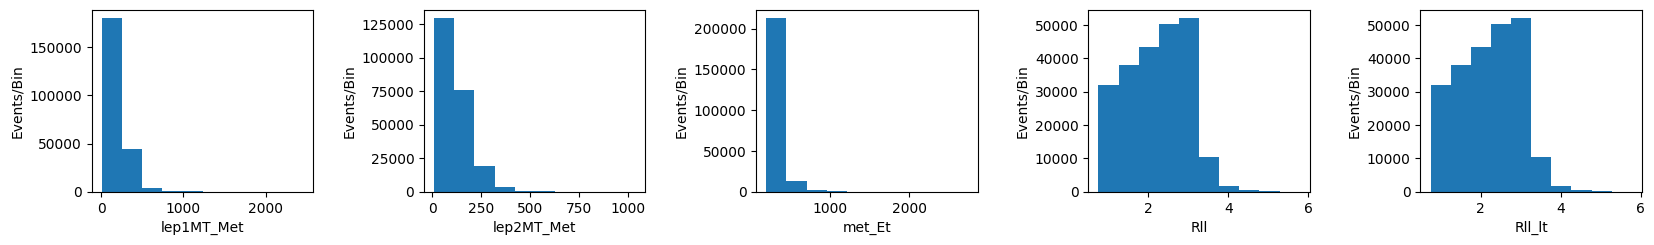

In [7]:
fig = plt.figure(figsize=(20,30))
fig.tight_layout()
for b in range(len(new_branches)):
    ax=fig.add_subplot(10,5,1+b)
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    ax.hist(x_train_before_scaling[new_branches[b]])
    ax.set_xlabel(new_branches[b])
    ax.set_ylabel("Events/Bin")

In [8]:
N=20000 # number of points
m=5 # dimensions

In [9]:
# now scale based on the training data:
sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [10]:
x_train_after_scaling={}
for b in new_branches:
    x_train_after_scaling[b]=[event[new_branches.index(b)] for event in x_train]

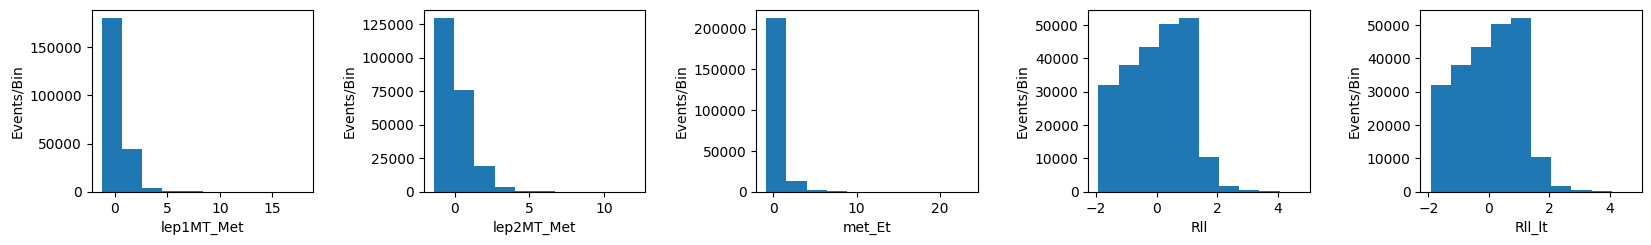

In [11]:
fig = plt.figure(figsize=(20,30))
fig.tight_layout()
for b in range(len(new_branches)):
    ax=fig.add_subplot(10,5,1+b)
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    ax.hist(x_train_after_scaling[new_branches[b]])
    ax.set_xlabel(new_branches[b])
    ax.set_ylabel("Events/Bin")

In [12]:
x_sig_data = np.transpose(x_sig_data)

x_bkg_data = np.transpose(x_bkg_data)

<Figure size 2000x500 with 0 Axes>

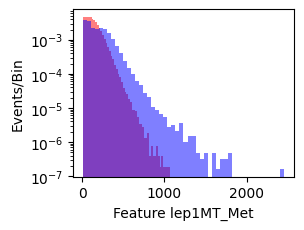

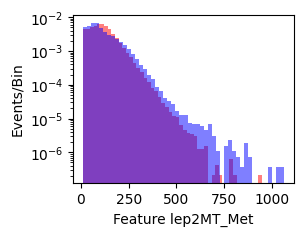

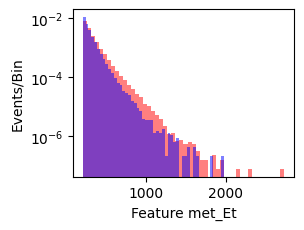

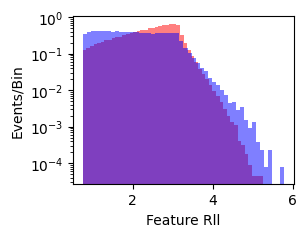

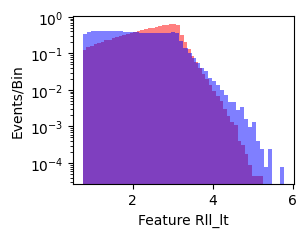

In [13]:
ig = plt.figure(figsize=(20,5))
fig.tight_layout()
nbins=50

for b in range(len(new_branches)):
    fig = plt.figure(figsize=(20,5))
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_sig_data[b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_bkg_data[b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"Feature {new_branches[b]}")
    ax.set_ylabel("Events/Bin")

In [14]:
torch.manual_seed(123)
net = torch.nn.Sequential(
    torch.nn.Linear(len(branches), 20),
    torch.nn.Tanh(),
    torch.nn.Linear(20, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 1)
)
torch.save(net.state_dict(), 'net.pth')
#loss_fn = torch.nn.MSELoss()
loss_fn = torch.nn.BCEWithLogitsLoss()
#optimizer = torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.9)
optimizer = torch.optim.Adam(net.parameters(), lr=0.02)

In [15]:
x_train_tensor=torch.tensor(x_train,dtype=torch.float)
y_train_tensor=torch.tensor(y_train,dtype=torch.float)
y_train_tensor=y_train_tensor.unsqueeze(1)

print(x_train_tensor.shape)

x_test_tensor=torch.tensor(x_test,dtype=torch.float)
y_test_tensor=torch.tensor(y_test,dtype=torch.float)
y_test_tensor=y_test_tensor.unsqueeze(1)

torch.Size([228431, 5])


In [16]:
import importlib
import LearningCutsUtils.LearningCutsUtils
## needed if we change LearningCutsUtils and want to avoid reloading the kernel to see the effects
importlib.reload(LearningCutsUtils.LearningCutsUtils)
import LearningCutsUtils.LearningCutsUtils as LCU
from LearningCutsUtils import loss_fn
from LearningCutsUtils import effic_loss_fn


N=20000 # number of points
m=5 # dimensions


Note: LearningCutsUtils classes and functions should now be imported directly from the LearningCutsUtils module, or from the corresponding submodule, e.g.:

from LearningCutsUtils import OneToOneLinear

or

from LearningCutsUtils.Utils import check_effics

Use of LearningCutsUtils.LearningCutsUtils is deprecated and support will be removed in a future commit.

Note: LearningCutsUtils classes and functions should now be imported directly from the LearningCutsUtils module, or from the corresponding submodule, e.g.:

from LearningCutsUtils import OneToOneLinear

or

from LearningCutsUtils.Utils import check_effics

Use of LearningCutsUtils.LearningCutsUtils is deprecated and support will be removed in a future commit.


In [17]:
gt=-1.
lt=1.

cuts_gt_lt = [lt, lt, gt, gt, lt]

In [18]:
def ES_Function(activation_input_scale_factor=15., learning_rate=0.1, batch_size=int(len(y_train)/20.), epochs = 50, alpha = 10., beta=0.1, gamma=1e-2, target_efficiency=0.8):
    torch.manual_seed(123)
    net = OneToOneLinear(m,activation_input_scale_factor,cuts_gt_lt)
    torch.save(net.state_dict(), 'net_learningbiases.pth')
    #optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
    {n: theta.shape for n, theta in net.named_parameters()}
    losses = []
    losses_test = []

    net.load_state_dict(torch.load('net_learningbiases.pth',weights_only=True))

    xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
    loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)
    debug=False

    for epoch in range(epochs):
        net.train()
        start_time = time.time()
        for x_batch, y_batch in loader:
            y_pred = net(x_batch)
            optimizer.zero_grad()
            loss = loss_fn(y_pred, y_batch.squeeze(1), m, net, target_efficiency, alpha, beta, gamma)
            loss.totalloss().backward()
            optimizer.step()
        losses.append(loss)
        net.eval() # configure the model for evaluation (testing)
        y_pred = net(x_test_tensor)
        test_loss =loss_fn(y_pred, y_test_tensor.squeeze(1), m, net, target_efficiency, alpha, beta, gamma)
        losses_test.append(test_loss)
        end_time=time.time()
        elapsed_time = end_time - start_time
        bias=net.bias[0]
        weight=net.weight[0]
        #weight={weight:4.1e}, bias={bias:4.1e}, 
        print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, Train loss={loss.totalloss().data:4.1e}, Test loss={test_loss.totalloss().data:4.1e}, cut={-bias/weight:4.1e}, sig_eff={100*test_loss.signaleffic:4.1f}%, bkg_eff={100*test_loss.backgreffic:6.3f}%")
    net.eval() # configure the model for evaluation (testing)
    y_pred_test = net(x_test_tensor).detach().cpu()
    y_pred_train= net(x_train_tensor).detach().cpu()
    LearningCutsUtils.LearningCutsUtils.make_ROC_curve(y_test, y_pred_test)
    return y_pred_test, y_pred_train

Completed epoch  0 in  4.1s, Train loss=6.4e+00, Test loss=6.4e+00, cut=-9.8e-03, sig_eff= 0.0%, bkg_eff= 0.234%
Completed epoch  1 in  3.9s, Train loss=6.4e+00, Test loss=6.4e+00, cut=-2.3e-02, sig_eff= 0.1%, bkg_eff= 0.316%
Completed epoch  2 in  2.8s, Train loss=6.4e+00, Test loss=6.4e+00, cut=-4.2e-02, sig_eff= 0.1%, bkg_eff= 0.446%
Completed epoch  3 in  5.0s, Train loss=6.4e+00, Test loss=6.4e+00, cut=-7.1e-02, sig_eff= 0.2%, bkg_eff= 0.664%
Completed epoch  4 in  3.5s, Train loss=6.4e+00, Test loss=6.3e+00, cut=-1.2e-01, sig_eff= 0.4%, bkg_eff= 1.053%
Completed epoch  5 in  2.7s, Train loss=6.3e+00, Test loss=6.2e+00, cut=-2.1e-01, sig_eff= 1.0%, bkg_eff= 1.858%
Completed epoch  6 in  3.4s, Train loss=6.3e+00, Test loss=5.8e+00, cut=-4.0e-01, sig_eff= 3.8%, bkg_eff= 4.312%
Completed epoch  7 in  4.9s, Train loss=5.8e+00, Test loss=2.6e+00, cut=-9.4e-01, sig_eff=28.8%, bkg_eff=21.529%
Completed epoch  8 in  3.1s, Train loss=2.6e+00, Test loss=1.2e-01, cut=-2.1e+00, sig_eff=72.0%,

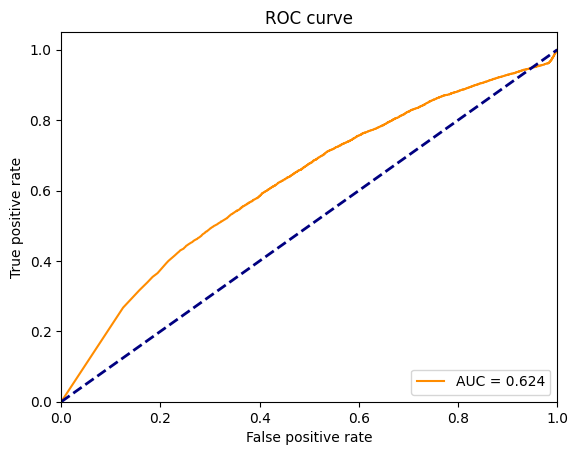

In [19]:
y_pred_test, y_pred_train = ES_Function(activation_input_scale_factor=15., learning_rate=0.5, batch_size=int(len(y_train)/1.), epochs = 200, alpha = 10., beta=0.1, gamma=10**(-5), target_efficiency=0.8)

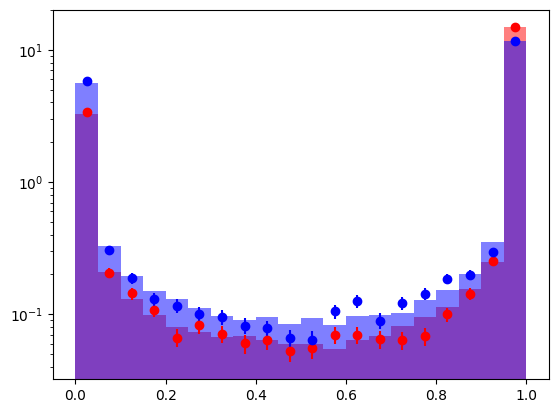

In [20]:
LCU.plot_classifier_output(y_train, y_pred_train, y_test, y_pred_test, nbins=20, range=(0,1))

In [21]:
def FC_Function(learning_rate, batch_size, epochs):
    torch.manual_seed(123)
    net = torch.nn.Sequential(
        torch.nn.Linear(m, 1,bias=False),
        torch.nn.Sigmoid()
    )
    torch.save(net.state_dict(), 'net_FC_untrained.pth')
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
    losses = []
    losses_test = []
    
    net.load_state_dict(torch.load('net_FC_untrained.pth',weights_only=True))
    
    xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
    loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

    debug=False

    for epoch in range(epochs):
        net.train()
        start_time = time.time()
        for x_batch, y_batch in loader:
        
            y_pred = net(x_batch).squeeze(1)
            optimizer.zero_grad()
            loss = torch.nn.BCELoss()(y_pred, y_batch.squeeze(1))
            loss.backward()
            optimizer.step()
        
        losses.append(loss.data)

        # configure the model for evaluation (testing)
        net.eval()
    
        y_pred = net(x_test_tensor).squeeze(1)
        test_loss = torch.nn.BCELoss()(y_pred, y_test_tensor.squeeze(1))
        losses_test.append(test_loss.data)
                
        end_time=time.time()
        elapsed_time = end_time - start_time
        print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, Train loss={loss.data:4.1e}, Test loss={test_loss.data:4.1e}")
    torch.save(net.state_dict(), 'net_FC_trained.pth')
    return losses, losses_test

In [22]:
losses, losses_test = FC_Function(learning_rate=0.5, batch_size=int(len(y_train)/1.), epochs=50)

Completed epoch  0 in  2.9s, Train loss=7.2e-01, Test loss=6.9e-01
Completed epoch  1 in  2.7s, Train loss=6.9e-01, Test loss=6.7e-01
Completed epoch  2 in  2.7s, Train loss=6.7e-01, Test loss=6.6e-01
Completed epoch  3 in  2.8s, Train loss=6.6e-01, Test loss=6.5e-01
Completed epoch  4 in  2.9s, Train loss=6.5e-01, Test loss=6.5e-01
Completed epoch  5 in  2.4s, Train loss=6.5e-01, Test loss=6.4e-01
Completed epoch  6 in  3.0s, Train loss=6.4e-01, Test loss=6.4e-01
Completed epoch  7 in  2.7s, Train loss=6.4e-01, Test loss=6.3e-01
Completed epoch  8 in  2.7s, Train loss=6.3e-01, Test loss=6.3e-01
Completed epoch  9 in  2.4s, Train loss=6.3e-01, Test loss=6.3e-01
Completed epoch 10 in  3.0s, Train loss=6.3e-01, Test loss=6.3e-01
Completed epoch 11 in  2.7s, Train loss=6.3e-01, Test loss=6.2e-01
Completed epoch 12 in  2.4s, Train loss=6.2e-01, Test loss=6.2e-01
Completed epoch 13 in  3.0s, Train loss=6.2e-01, Test loss=6.2e-01
Completed epoch 14 in  2.8s, Train loss=6.2e-01, Test loss=6.2

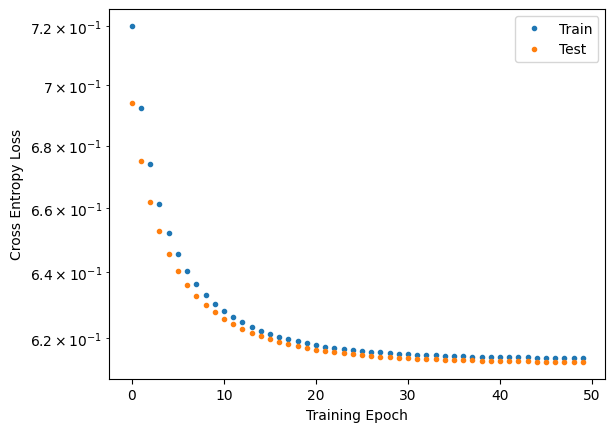

In [23]:
plt.plot(losses, '.', label="Train")
plt.plot(losses_test, '.', label="Test")
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('Cross Entropy Loss')
plt.yscale('log');